In [2]:
import sys
sys.path.append('../../../models/ZoeDepth/')

import torch
from zoedepth.models.builder import build_model
from zoedepth.utils.config import get_config
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import csv
import pandas as pd
from PIL import Image
from pprint import pprint

In [3]:
NYU_dataset_path = "/home/ashkanganj/workspace/dataset/nyu_depth_v2/official_splits/test"
test_split_nyu_path = "../../../models/ZoeDepth/train_test_inputs/nyudepthv2_test_files_with_gt.txt"

In [4]:
# read test split
with open(test_split_nyu_path, 'r') as f:
    test_split = f.readlines()
test_split = [x.strip() for x in test_split]


In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
if DEVICE == "cpu":
    print("WARNING: Running on CPU. This will be slow. Check your CUDA installation.")

pretrained_resource_org = 'url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_N.pt'

overwrite = {"pretrained_resource": pretrained_resource_org}
conf = get_config("zoedepth", "infer",**overwrite)
print(conf['pretrained_resource'])

print("Config:")
pprint(conf)

model_pretrained = build_model(conf).to(DEVICE)
model_pretrained.eval()

cuda
url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_N.pt
Config:
{'attractor_alpha': 1000,
 'attractor_gamma': 2,
 'attractor_kind': 'mean',
 'attractor_type': 'inv',
 'aug': False,
 'bin_centers_type': 'softplus',
 'bin_embedding_dim': 128,
 'clip_grad': 0.1,
 'dataset': 'ARkitScenes',
 'distributed': True,
 'force_keep_ar': True,
 'gpu': None,
 'img_size': [384, 512],
 'inverse_midas': False,
 'log_images_every': 0.1,
 'max_temp': 50.0,
 'max_translation': 100,
 'memory_efficient': True,
 'midas_model_type': 'DPT_BEiT_L_384',
 'min_temp': 0.0212,
 'model': 'zoedepth',
 'n_attractors': [16, 8, 4, 1],
 'n_bins': 64,
 'name': 'ZoeDepth',
 'notes': '',
 'output_distribution': 'logbinomial',
 'prefetch': False,
 'pretrained_resource': 'url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_N.pt',
 'print_losses': False,
 'project': 'ZoeDepth',
 'random_crop': False,
 'random_translate': False,
 'root': '.',
 'save_dir': '/home/ashka/ZoeDepth/che

Using cache found in /home/ashkanganj/.cache/torch/hub/intel-isl_MiDaS_master
/home/ashkanganj/anaconda3/envs/torch/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449181202/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_N.pt
Loaded successfully


ZoeDepth(
  (core): MidasCore(
    (core): DPTDepthModel(
      (pretrained): Module(
        (model): Beit(
          (patch_embed): PatchEmbed(
            (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
            (norm): Identity()
          )
          (pos_drop): Dropout(p=0.0, inplace=False)
          (blocks): ModuleList(
            (0-23): 24 x Block(
              (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
              (attn): Attention(
                (qkv): Linear(in_features=1024, out_features=3072, bias=False)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=1024, out_features=1024, bias=True)
                (proj_drop): Dropout(p=0.0, inplace=False)
              )
              (drop_path): Identity()
              (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
              (mlp): Mlp(
                (fc1): Linear(in_features=1024, out_features=4096, bias=Tru

In [6]:
def read_images(img_path, gt_path):
    gt_depth = cv2.imread(gt_path, cv2.IMREAD_ANYDEPTH)
    image = cv2.imread(img_path)
    
    return image, gt_depth


def rmse_valid_depths(predicted, gt):
    valid_mask = (gt > 1e-3) & (gt < 10)

    # Calculate the squared difference between the two depth maps.
    sq_diff = (predicted - gt)**2

    # Calculate the mean squared difference for only valid depths.
    mse_valid = np.mean(sq_diff[valid_mask])

    # Calculate the RMSE for only valid depths.
    rmse_valid = np.sqrt(mse_valid)

    return rmse_valid



def relative_error_loss(predicted, gt):
    # Create a mask for valid pixels where ground truth values are greater than zero.
    valid_mask = (gt > 1e-3) & (gt < 10)

    # Calculate the absolute difference between the predicted and ground truth depth maps.
    abs_diff = np.abs(predicted[valid_mask] - gt[valid_mask])

    # Calculate the relative error loss using the valid mask.
    rel_loss = np.mean(abs_diff / gt[valid_mask])

    return rel_loss



def absolute_relative_error(predicted, gt):
    valid_mask = (gt > 1e-3) & (gt < 10)

    # Calculate the absolute difference between the two depth maps.
    abs_diff = np.abs(predicted - gt)

    # Calculate the absolute relative error.
    abs_rel_err = np.mean(abs_diff[valid_mask] / predicted[valid_mask])

    return abs_rel_err

def calculate_errors(predicted, gt):
    # calculate rmse and abs_rel_err
    rmse = rmse_valid_depths(predicted, gt)
    abs_rel_err = relative_error_loss(predicted, gt)
    
    return rmse, abs_rel_err


def crop_image(image, crop_percentage):
    height, width = image.shape[:2]
    new_height = int(height - (height * crop_percentage / 100))
    new_width = int(width - (width * crop_percentage / 100))
    start_x = (width - new_width) // 2
    start_y = (height - new_height) // 2
    return image[start_y:start_y + new_height, start_x:start_x + new_width]


# An Example


In [7]:
example_img_path = os.path.join(NYU_dataset_path,test_split[0].split()[0])
example_gt_depth_path = os.path.join(NYU_dataset_path,test_split[0].split()[1])

In [8]:
example_img, example_gt_depth = read_images(example_img_path, example_gt_depth_path)
example_gt_depth = example_gt_depth.astype(np.float32) / 1000.0

In [9]:
# convert my image to Pillow Image
example_img = Image.fromarray(example_img)

In [10]:
# Specify the output directory where the cropped images will be saved
output_dir = "/path/to/output/directory/"

# Save the cropped image
cv2.imwrite(output_dir + "cropped_image.jpg", cropped_image)


NameError: name 'cropped_image' is not defined

In [11]:
pred_depth = model_pretrained.infer_pil(example_img)

TypeError: expected size to be one of int or Tuple[int] or Tuple[int, int] or Tuple[int, int, int], but got size with types [<class 'numpy.int64'>, <class 'numpy.int64'>]

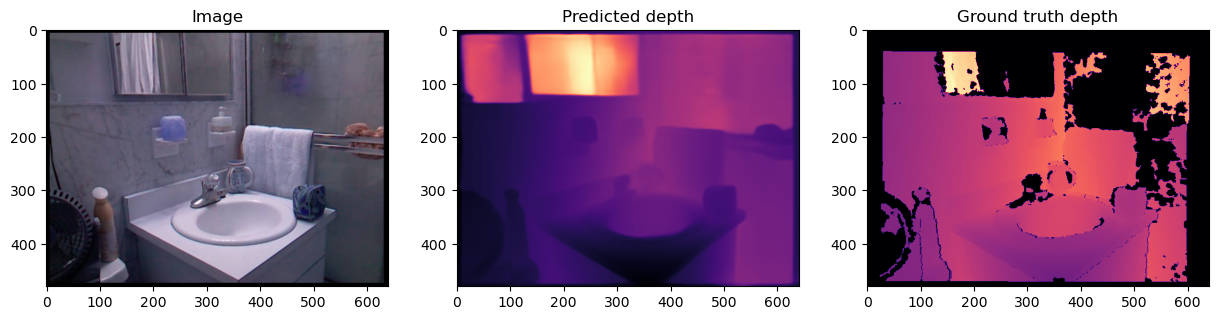

In [ ]:
# visualize example image and depth with predicted depth and ground truth depth
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(example_img)
ax[0].set_title("Image")
ax[1].imshow(pred_depth, cmap='magma')
ax[1].set_title("Predicted depth")
ax[2].imshow(example_gt_depth, cmap='magma')
ax[2].set_title("Ground truth depth")
plt.show()

In [ ]:
# calculate rmse and abs_rel
rmse  ,abs_rel = calculate_errors(pred_depth, example_gt_depth)
print("RMSE: ", rmse)
print("Abs_rel: ", abs_rel)

RMSE:  0.37215155
Abs_rel:  0.29301113


In [ ]:
# crop image and depth
example_img_cropped = crop_image(example_img, 50)
example_gt_depth_cropped = crop_image(example_gt_depth, 50)
pred_depth_cropped = model_pretrained.infer_pil(example_img_cropped)

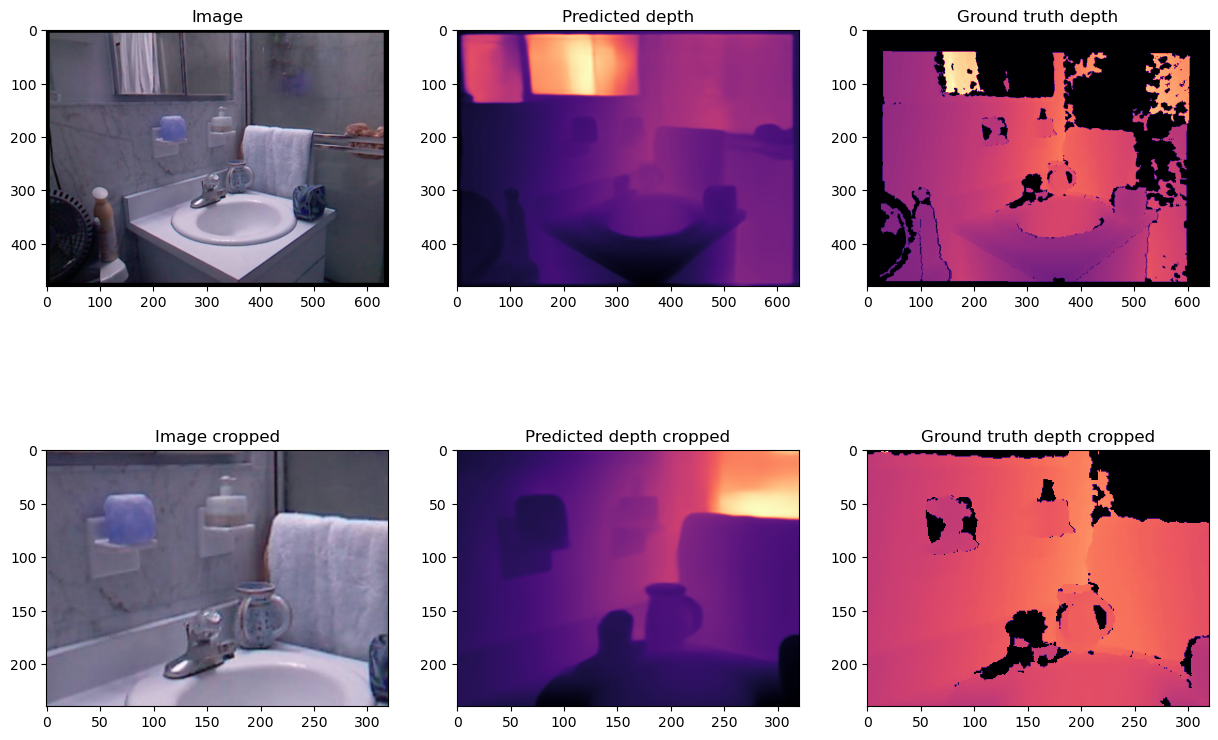

RMSE:  0.07785019
Abs_rel:  0.049389653


In [ ]:
# visualize example image and depth with predicted depth and ground truth depth vs cropped image and depth
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax[0, 0].imshow(example_img)
ax[0, 0].set_title("Image")
ax[0, 1].imshow(pred_depth, cmap='magma')
ax[0, 1].set_title("Predicted depth")
ax[0, 2].imshow(example_gt_depth, cmap='magma')
ax[0, 2].set_title("Ground truth depth")
ax[1, 0].imshow(example_img_cropped)
ax[1, 0].set_title("Image cropped")
ax[1, 1].imshow(pred_depth_cropped, cmap='magma')
ax[1, 1].set_title("Predicted depth cropped")
ax[1, 2].imshow(example_gt_depth_cropped, cmap='magma')
ax[1, 2].set_title("Ground truth depth cropped")
plt.show()


# calculate rmse and abs_rel
rmse  ,abs_rel = calculate_errors(pred_depth_cropped, example_gt_depth_cropped)
print("RMSE: ", rmse)
print("Abs_rel: ", abs_rel)


## Run on all the test split of NYU

In [ ]:
cropped_percentage = [75, 50, 25]

with open('cropped_percentage.csv', mode='w') as csv_file:
    fieldnames = ['sample', 'cropped_percentage', 'rmse_org',
                  'rel_org', 'rmse_cropped', 'rel_cropped']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()

    for cropped_percentage in cropped_percentage:
        rmse_list = []
        abs_rel_list = []
        for sample in test_split:
            org_image, org_gt_depth = read_images(os.path.join(NYU_dataset_path, sample.split()[
                                                  0]), os.path.join(NYU_dataset_path, sample.split()[1]))
            cropped_image = crop_image(org_image, cropped_percentage)
            cropped_gt_depth = crop_image(org_gt_depth, cropped_percentage)

            org_gt_depth = org_gt_depth.astype(np.float32) / 1000.0
            cropped_gt_depth = cropped_gt_depth.astype(np.float32) / 1000.0

            pred_depth = model_pretrained.infer_pil(org_image)
            pred_depth_cropped = model_pretrained.infer_pil(cropped_image)

            rmse_org, rel_org = calculate_errors(pred_depth, org_gt_depth)
            rmse_cropped, rel_cropped = calculate_errors(
                pred_depth_cropped, cropped_gt_depth)

            # write to csv file
            writer.writerow({'sample': sample, 'cropped_percentage': cropped_percentage, 'rmse_org': rmse_org,
                            'rel_org': rel_org, 'rmse_cropped': rmse_cropped, 'rel_cropped': rel_cropped})


TypeError: expected size to be one of int or Tuple[int] or Tuple[int, int] or Tuple[int, int, int], but got size with types [<class 'numpy.int64'>, <class 'numpy.int64'>]

In [ ]:
file_path = '/home/ashkanganj/workspace/ZoeDepth/notebooks/cropped_percentage.csv'
data = pd.read_csv(file_path)
data.head()


,sample,cropped_percentage,rmse_org,rel_org,rmse_cropped,rel_cropped
0,bathroom/rgb_00045.jpg bathroom/sync_depth_000...,75,0.372152,0.293011,0.230242,0.117587
1,bathroom/rgb_00046.jpg bathroom/sync_depth_000...,75,0.228066,0.073978,0.920136,0.403225
2,bathroom/rgb_00507.jpg bathroom/sync_depth_005...,75,0.258802,0.092091,1.274229,0.546498
3,bathroom/rgb_00508.jpg bathroom/sync_depth_005...,75,0.365724,0.147570,1.040984,0.350892
4,bathroom/rgb_00509.jpg bathroom/sync_depth_005...,75,0.263708,0.111023,0.573055,0.278616


In [ ]:
data.describe()

,cropped_percentage,rmse_org,rel_org,rmse_cropped,rel_cropped
count,1962.000000,1962.000000,1962.000000,1962.000000,1962.000000
mean,50.000000,0.399446,0.134950,0.966193,0.272821
std,20.417618,0.216121,0.069812,0.793887,0.163824
min,25.000000,0.075676,0.020658,0.057094,0.018248
25%,25.000000,0.250608,0.085762,0.396806,0.130390
50%,50.000000,0.355536,0.124220,0.751753,0.255190
75%,75.000000,0.490175,0.170558,1.319768,0.384830
max,75.000000,1.866261,0.456022,7.553241,0.766497


In [ ]:
# give me mean of rmse cropped and rel cropped for each cropped percentage

data.groupby(['cropped_percentage']).mean()


/tmp/ipykernel_2901184/560988943.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data.groupby(['cropped_percentage']).mean()


,rmse_org,rel_org,rmse_cropped,rel_cropped
cropped_percentage,,,,
25,0.399446,0.13495,0.438080,0.119450
50,0.399446,0.13495,0.934928,0.272415
75,0.399446,0.13495,1.525572,0.426599


In [ ]:
# Grouping the data by cropping percentage to get the mean values for each percentage
grouped_data = data.groupby('cropped_percentage').mean().reset_index()

# update all 'rmse_org and rel_org' values to  0.270 and  0.075 respectively
grouped_data['rmse_org'] = 0.270
grouped_data['rel_org'] = 0.075


/tmp/ipykernel_948140/323576931.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_data = data.groupby('cropped_percentage').mean().reset_index()


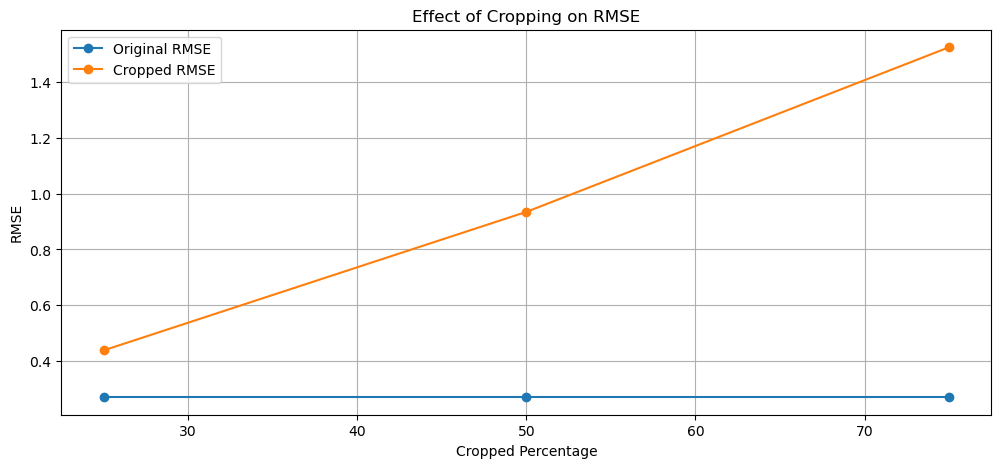

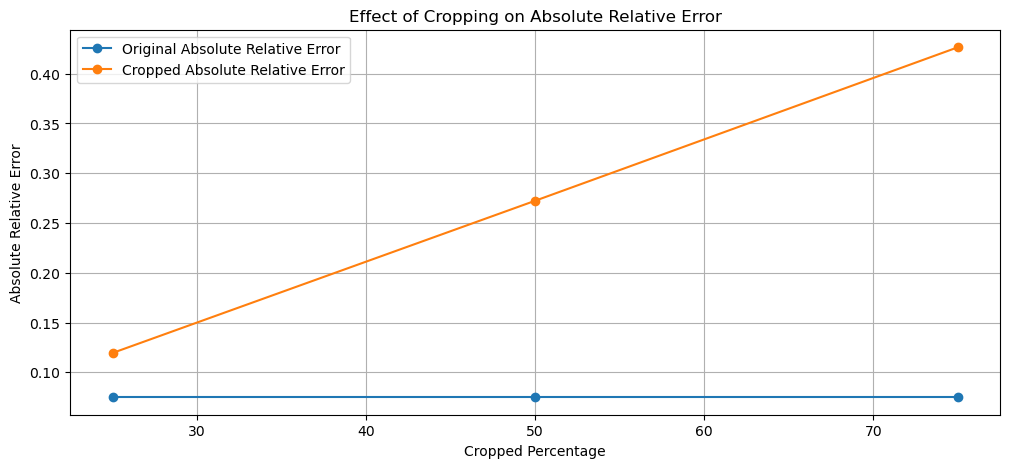

In [ ]:
# Plotting RMSE
plt.figure(figsize=[12, 5])
plt.plot(grouped_data['cropped_percentage'], grouped_data['rmse_org'], label='Original RMSE', marker='o')
plt.plot(grouped_data['cropped_percentage'], grouped_data['rmse_cropped'], label='Cropped RMSE' , marker='o')
plt.xlabel('Cropped Percentage')
plt.ylabel('RMSE')
plt.title('Effect of Cropping on RMSE')
plt.legend()
plt.grid(True)
plt.savefig('cropped_rmse.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Plotting Absolute Relative Error
plt.figure(figsize=[12, 5])
plt.plot(grouped_data['cropped_percentage'], grouped_data['rel_org'], label='Original Absolute Relative Error' , marker='o')
plt.plot(grouped_data['cropped_percentage'], grouped_data['rel_cropped'], label='Cropped Absolute Relative Error' , marker='o')
plt.xlabel('Cropped Percentage')
plt.ylabel('Absolute Relative Error')
plt.title('Effect of Cropping on Absolute Relative Error')
plt.legend()
plt.grid(True)
plt.savefig('cropped_rel.pdf', dpi=300, bbox_inches='tight')
plt.show()